In [33]:
import Pkg
packages = [
    "BoundaryValueDiffEq",
    "ModelingToolkit",
    "MethodOfLines",
    "DifferentialEquations",
    "NonlinearSolve",
    "DomainSets",
    "FFTW",
    "Plots",
    "BifurcationKit",
    "LinearAlgebra",
    "SparseArrays",
    "Setfield",
]

Pkg.add(packages)

   Resolving package versions...
  No Changes to `C:\Users\justn\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\justn\.julia\environments\v1.11\Manifest.toml`


In [34]:
using LinearAlgebra
using BoundaryValueDiffEq
using SparseArrays
using ModelingToolkit
using MethodOfLines
using DifferentialEquations
using NonlinearSolve
using DomainSets
using FFTW
using Plots
using BifurcationKit
using Setfield 

In [35]:
# 1. Define the Nonlinear ODE Function
function driven_oscillator!(du, u, p, t)
    # u[1] = x (position)
    # u[2] = v (velocity)
    du[1] = u[2]
    
    # Equation: m*x'' + c*x' + gamma*(x')^3 + k*x + alpha*x^3 = F*cos(omega*t)
    
    force_driving = p.F * cos(p.omega * t)
    damping_term  = p.c * u[2] + p.gamma * (u[2]^3)  # cubic damping
    stiffness_term = p.k * u[1] + p.alpha * (u[1]^3) # cubic stiffness
    
    du[2] = (force_driving - damping_term - stiffness_term) / p.m
end

# 2. Parameters 
par_osc = (m = 1.0, k = 1.0, c = 0.5, alpha = 0, gamma = 0, F = 0.5, omega = 0.1)

(m = 1.0, k = 1.0, c = 0.5, alpha = 0, gamma = 0, F = 0.5, omega = 0.1)

In [36]:
# 3. Poincaré Map 
function poincare_map(u, p)
    T = 2π / p.omega
    prob = ODEProblem(driven_oscillator!, u, (0.0, T), p)
    sol = solve(prob, RK4(), reltol=1e-9, abstol=1e-9, save_everystep=false)
    return sol[end] - u
end

poincare_map (generic function with 1 method)

In [37]:
# 4. Define the Bifurcation Problem
u0 = [0.1, 0.0] 

prob = BifurcationProblem(poincare_map, u0, par_osc, (@optic _.omega);
    record_from_solution = (x, p; k...) -> begin
        
        current_omega = (p isa Real) ? p : p.omega
        
        p_full = (
            m=par_osc.m, 
            k=par_osc.k, 
            c=par_osc.c, 
            alpha=par_osc.alpha, 
            gamma=par_osc.gamma, 
            F=par_osc.F, 
            omega=Float64(current_omega)
        )

        T = 2π / p_full.omega
        
        # Re-integrate for max amplitude
        prob_rec = ODEProblem(driven_oscillator!, x, (0.0, T), p_full)
        sol_rec = solve(prob_rec, Tsit5(), reltol=1e-8, abstol=1e-8)
        
        return maximum(abs.(sol_rec[1, :]))
    end
)

┌─ Bifurcation Problem with uType Vector{Float64}
├─ Inplace: false
├─ Dimension: 2
├─ Symmetric: false
└─ Parameter: omega

In [38]:
# 5. Continuation Options 
opts = ContinuationPar(
    p_min = 0.1, 
    p_max = 5.0,      
    ds = 0.01,        
    dsmax = 0.05,
    max_steps = 10000,
    detect_bifurcation = 0, 
    newton_options = NewtonPar(tol = 1e-9, max_iterations = 20) 
)

ContinuationPar{Float64, DefaultLS, DefaultEig{typeof(real)}}
  dsmin: Float64 0.0001
  dsmax: Float64 0.05
  ds: Float64 0.01
  a: Float64 0.5
  p_min: Float64 0.1
  p_max: Float64 5.0
  max_steps: Int64 10000
  newton_options: NewtonPar{Float64, DefaultLS, DefaultEig{typeof(real)}}
  η: Float64 150.0
  save_to_file: Bool false
  save_sol_every_step: Int64 1
  nev: Int64 3
  save_eig_every_step: Int64 1
  save_eigenvectors: Bool true
  plot_every_step: Int64 10
  tol_stability: Float64 1.0e-10
  detect_fold: Bool true
  detect_bifurcation: Int64 0
  dsmin_bisection: Float64 1.0e-16
  n_inversion: Int64 2
  max_bisection_steps: Int64 25
  tol_bisection_eigenvalue: Float64 1.0e-16
  detect_event: Int64 0
  tol_param_bisection_event: Float64 1.0e-16
  detect_loop: Bool false


In [39]:
# 6. Perform Continuation
@time branch = continuation(prob, PALC(), opts)

  2.746437 seconds (2.58 M allocations: 132.241 MiB, 91.63% compilation time: 10% of which was recompilation)


 ┌─ Curve type: EquilibriumCont
 ├─ Number of points: 87
 ├─ Type of vectors: Vector{Float64}
 ├─ Parameter omega starts at 0.1, ends at 5.0
 ├─ Algo: PALC [Secant]
 └─ Special points:

- #  1, endpoint at omega ≈ +5.00000000,                                                                     step =  86


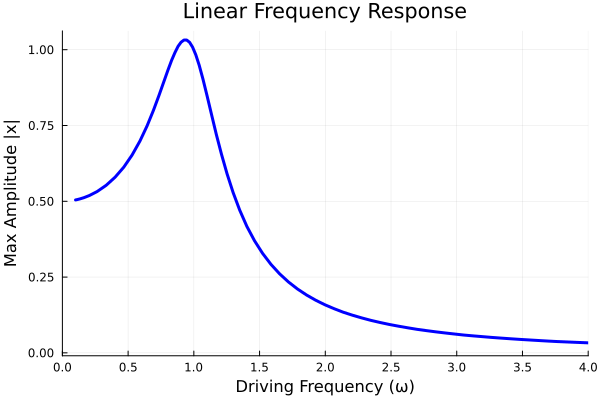

In [40]:
# 7. Plotting
plot(branch, 
    title = "Linear Frequency Response",
    xlabel = "Driving Frequency (ω)",
    ylabel = "Max Amplitude |x|",
    lw = 3, color = :blue, 
    legend = false,
    xlims = (0, 4),
    xticks = 0:0.5:4,
)